THe aim of this is to investigate why the loss is not improving with an increase in the size of the neural net
# 3 layers

In [1]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

# for as much consistency as possible:
torch.manual_seed(1337)

# Data processing and extraction
data = open("data/essays.txt", "r").read()
character_set = sorted(list(set(data)))

# creating of character level encoding
stoi = {s: i for i, s in enumerate(character_set)}
itos = {i: s for i, s in enumerate(character_set)}

# ----- Global Parameters -----
CONTEXT_LENGTH = 8
BATCH_SIZE = 4
VOCAB_SIZE = len(character_set)
HIDDEN_LAYER = 32
lr = 1e-3
training_rounds = 10000
# -----------------------------


# encoding and decoding functions
def encode(input):
    """Return the string to integer encoding for the input sequence"""
    return [stoi[s] for s in input]


def decode(input):
    """Based on the input sequence of integers, return it a string"""
    return "".join([itos[i] for i in input])


# preparing the training and testing splits
n = int(len(data) * 0.9)
train = torch.tensor(encode(data[:n]))
val = torch.tensor(encode(data[n:]))


def get_batch(data_set):
    """Generate a batch of learning examples and targets from the data set"""
    # get a BATCH_SIZEW number of random integers
    indexes = torch.randint(len(data_set) - CONTEXT_LENGTH, (BATCH_SIZE,))
    # Get BATCH_SIZE length of inputs to mask later.
    Xb = torch.stack([data_set[i : i + CONTEXT_LENGTH] for i in indexes], dim=0)
    # Get the corresponding targets
    Yb = torch.stack([data_set[i + 1 : i + CONTEXT_LENGTH + 1] for i in indexes], dim=0)
    return Xb, Yb


# give the model a way to evaluate its loss
@torch.no_grad
def get_loss(model, loss_evals):
    """Evaluate the mean loss for both training and validation batches"""
    losses_tr, losses_val = [], []
    for _ in range(loss_evals):
        Xtr, Ytr = get_batch(train)
        Xval, Yval = get_batch(val)

        logits_tr, loss_tr = model(Xtr, Ytr)
        losses_tr.append(loss_tr.item())

        logits_val, loss_val = model(Xval, Yval)
        losses_val.append(loss_val.item())

    tr_avg_loss = torch.tensor(losses_tr, dtype=torch.float).mean()
    val_avg_loss = torch.tensor(losses_val, dtype=torch.float).mean()
    print(f"Train loss: {tr_avg_loss:.5f} | Val loss: {val_avg_loss:.5f}")


# making a head of self-attention *squeals*
class SelfAttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.head_size = head_size
        # each block of self-attention will have 3 values: Query, Key, Value
        self.queries = nn.Linear(in_features=HIDDEN_LAYER, out_features=head_size)
        self.keys = nn.Linear(in_features=HIDDEN_LAYER, out_features=head_size)
        self.values = nn.Linear(in_features=HIDDEN_LAYER, out_features=head_size)

        # then create the mask
        self.register_buffer(
            "tril", torch.tril(torch.ones((CONTEXT_LENGTH, CONTEXT_LENGTH)))
        )

    def forward(self, x):
        # process the shape of the inputs so that the masked fill can occur even if the input size is less than CONTEXT LENGTH
        B, T, C = x.shape

        # generate the Q and K values for each input
        Q: Tensor = self.queries(x)
        K: Tensor = self.keys(x)
        # create the weights RMB TO SCALE!
        wei = Q @ K.transpose(-1, -2) * self.head_size**-0.5
        # **** this line with T is kind of sketchy welps, will have to dig further later ****
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, -1)

        # produce the V
        V = self.values(x)

        # determine the weighted result
        out = wei @ V
        return out


class MultiHeadedAttention(nn.Module):
    def __init__(self, number_of_heads, head_size):
        super().__init__()
        self.multi_headed_attention_block = nn.ModuleList(
            [SelfAttentionHead(head_size) for _ in range(number_of_heads)]
        )

    def forward(self, x):
        # since the multi-attention head requires the splitting of the channels among the heads, this joins back the channels
        out = torch.cat(
            [attn_head(x) for attn_head in self.multi_headed_attention_block], dim=-1
        )
        return out


class FeedForward(nn.Module):
    """This block gives tokens the time to think"""

    def __init__(self, in_features, out_features):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features), nn.ReLU()
        )

    def forward(self, x):
        out = self.ff(x)
        return out


class Block(nn.Module):
    """Enables communication (multi-headed self-attention), then computation (feed-forward)"""

    def __init__(self, hidden_layer_size, no_of_heads):
        super().__init__()
        multi_attn_head_size = hidden_layer_size // no_of_heads
        self.multi_attn = MultiHeadedAttention(no_of_heads, multi_attn_head_size)
        self.ffwd = FeedForward(hidden_layer_size, hidden_layer_size)

    def forward(self, x):
        x = self.multi_attn(x)
        x = self.ffwd(x)
        self.out = x
        return x


# creation of the model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(
            num_embeddings=VOCAB_SIZE, embedding_dim=HIDDEN_LAYER
        )
        # besides the identity of the tokens, we also wish to embed the postition of the tokens
        self.position_embedding_table = nn.Embedding(
            num_embeddings=CONTEXT_LENGTH, embedding_dim=HIDDEN_LAYER
        )
        # self.blocks = nn.Sequential(
        #     Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        #     # Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        #     # Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        # )
        self.block1 = Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4)
        self.block2 = Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4)
        self.block3 = Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4)

        # self.multi_head = MultiHeadedAttention(4, HIDDEN_LAYER // 4)
        # self.ffwd = FeedForward(HIDDEN_LAYER, HIDDEN_LAYER)
        self.lm_head = nn.Linear(in_features=HIDDEN_LAYER, out_features=VOCAB_SIZE)

    def forward(self, x, targets=None):
        """Do a forward pass of the NN. Returns loss if targets are given"""
        # get the shape of the input so that the postitional outputs can be properly computed when the input size is less than 8
        B, T = x.shape

        token_logits: Tensor = self.token_embedding_table(x)
        postition_logits: Tensor = self.position_embedding_table(torch.arange(T))
        input_tokens = token_logits + postition_logits
        # weighted_tokens = self.multi_head(input_tokens)
        # feed_forward = self.ffwd(weighted_tokens)
        feed_forward = self.block1(input_tokens)
        feed_forward = self.block2(feed_forward)
        feed_forward = self.block3(feed_forward)
        logits: Tensor = self.lm_head(feed_forward)

        # if there are targets present, perform a calculation of the loss
        if targets != None:
            # B: number of batches, T: the context length, C: the number of outputs
            B, T, C = logits.shape
            # order the logits in the form: (minibatch,C) to enable cross_entropy calculation
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
            return logits, loss

        return logits

    def generate(self, x, max_tokens=10):
        """Receives a (B, T) input token and creates tokens based on the input"""
        for _ in range(max_tokens):
            # get the last CONTEXT LENGTH number of tokens from the input sequence
            context = x[:, -CONTEXT_LENGTH:]
            logits = self(context)
            # we are only interested in the logits of the last character
            last_char_logits = logits[:, -1, :]  # (1, 88)
            # take the last embedding, since that is all that we are concerned about
            probs = F.softmax(
                last_char_logits, dim=1
            )  # the result of this is that all values along dim 1 will sum to 1
            next_char = torch.multinomial(probs, 1)
            x = torch.cat(
                [x, next_char], dim=1
            )  # addition is perfomed along dim=1 here because they all belong in the same batch
        return x

In [2]:
# try to perform one training round
m = Model()
optimizer = torch.optim.AdamW(params=m.parameters(), lr=lr)

for i in range(training_rounds):
    Xtr, Ytr = get_batch(train)
    # forward pass
    logits, loss = m(Xtr, Ytr)

    # print the loss at regular intervals
    if i % 1000 == 0:
        get_loss(m, 500)

    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Train loss: 4.49254 | Val loss: 4.48979
Train loss: 2.94325 | Val loss: 2.93754
Train loss: 2.80458 | Val loss: 2.82144
Train loss: 2.61479 | Val loss: 2.61669
Train loss: 2.54685 | Val loss: 2.56638
Train loss: 2.47567 | Val loss: 2.50713
Train loss: 2.43373 | Val loss: 2.44476
Train loss: 2.40536 | Val loss: 2.40891
Train loss: 2.35152 | Val loss: 2.36069
Train loss: 2.33025 | Val loss: 2.38942


In [3]:
import matplotlib.pyplot as plt

tensor([487.,   6.,   5.,   8.,   8.,   8.,   1.,   5.,   3.,   2.,   5.,   6.,
          9.,   4.,   4.,   7.,   6.,   4.,   8.,   5.,   4.,   5.,  10.,   2.,
          4.,   2.,   5.,   7.,   5.,   4.], grad_fn=<NotImplemented>) tensor([0.0000, 0.0267, 0.0533, 0.0800, 0.1067, 0.1333, 0.1600, 0.1867, 0.2133,
        0.2400, 0.2667, 0.2933, 0.3200, 0.3467, 0.3733, 0.4000, 0.4267, 0.4533,
        0.4800, 0.5067, 0.5333, 0.5600, 0.5867, 0.6133, 0.6400, 0.6667, 0.6933,
        0.7200, 0.7467, 0.7733, 0.8000], grad_fn=<NotImplemented>)
torch.Size([481])


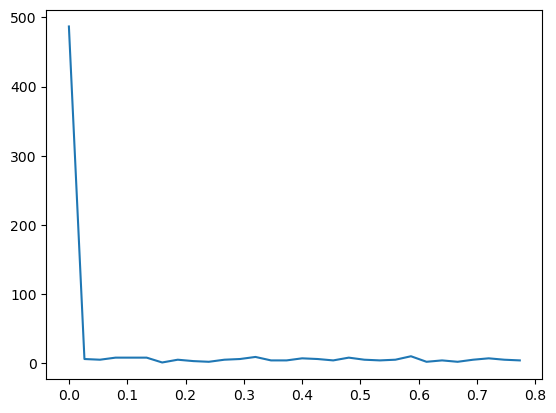

In [4]:
# plot the data on a graph to check out what is going on
hy, hx = torch.histogram(m.block1.out, bins=30, range=(0, 0.8))
print(hy, hx)
plt.plot(hx.detach()[:-1], hy.detach())

# check the number of values that are less than or equal to 0
zero_mask1 = torch.le(m.block1.out, 0)
zeros = m.block1.out[zero_mask1]
three_block_layer1 = zeros.shape
print(zeros.shape)

tensor([591.,   6.,   4.,   4.,   4.,   5.,   5.,   1.,   3.,   3.,   3.,   4.,
          3.,   3.,   2.,   2.,   4.,   5.,   2.,   4.,   3.,   3.,   2.,   3.,
          3.,   3.,   1.,   4.,   4.,   8.], grad_fn=<NotImplemented>) tensor([0.0000, 0.0267, 0.0533, 0.0800, 0.1067, 0.1333, 0.1600, 0.1867, 0.2133,
        0.2400, 0.2667, 0.2933, 0.3200, 0.3467, 0.3733, 0.4000, 0.4267, 0.4533,
        0.4800, 0.5067, 0.5333, 0.5600, 0.5867, 0.6133, 0.6400, 0.6667, 0.6933,
        0.7200, 0.7467, 0.7733, 0.8000], grad_fn=<NotImplemented>)
torch.Size([590])


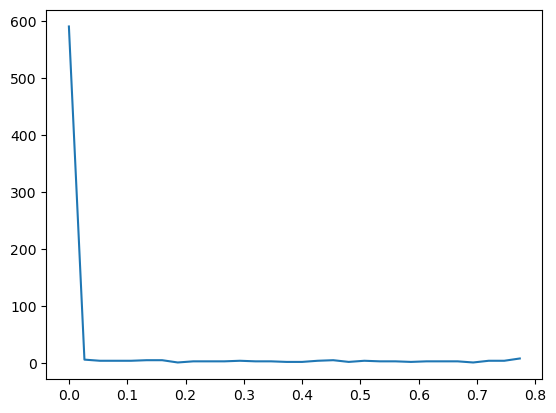

In [5]:
# plot the data on a graph to check out what is going on
hy, hx = torch.histogram(m.block2.out, bins=30, range=(0, 0.8))
print(hy, hx)
plt.plot(hx.detach()[:-1], hy.detach())

# check the number of values that are less than or equal to 0
zero_mask1 = torch.le(m.block2.out, 0)
zeros = m.block2.out[zero_mask1]
three_block_layer2 = zeros.shape
print(zeros.shape)

tensor([509.,   7.,   4.,   6.,   2.,   5.,   4.,   4.,   5.,   6.,   2.,   2.,
          5.,   6.,   8.,   4.,   3.,   3.,   3.,   4.,   7.,   3.,   7.,  11.,
          9.,   4.,   5.,   3.,   6.,   7.], grad_fn=<NotImplemented>) tensor([0.0000, 0.0267, 0.0533, 0.0800, 0.1067, 0.1333, 0.1600, 0.1867, 0.2133,
        0.2400, 0.2667, 0.2933, 0.3200, 0.3467, 0.3733, 0.4000, 0.4267, 0.4533,
        0.4800, 0.5067, 0.5333, 0.5600, 0.5867, 0.6133, 0.6400, 0.6667, 0.6933,
        0.7200, 0.7467, 0.7733, 0.8000], grad_fn=<NotImplemented>)
torch.Size([502])


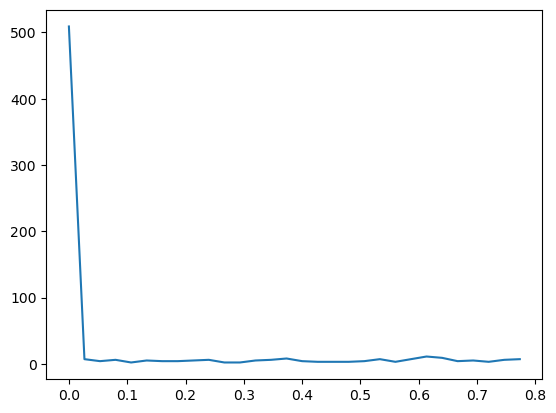

In [6]:
# plot the data on a graph to check out what is going on
hy, hx = torch.histogram(m.block3.out, bins=30, range=(0, 0.8))
print(hy, hx)
plt.plot(hx.detach()[:-1], hy.detach())

# check the number of values that are less than or equal to 0
zero_mask1 = torch.le(m.block3.out, 0)
zeros = m.block3.out[zero_mask1]
three_block_layer3 = zeros.shape
print(zeros.shape)

In [7]:
# for as much consistency as possible:
torch.manual_seed(1337)

# creation of the model
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(
            num_embeddings=VOCAB_SIZE, embedding_dim=HIDDEN_LAYER
        )
        # besides the identity of the tokens, we also wish to embed the postition of the tokens
        self.position_embedding_table = nn.Embedding(
            num_embeddings=CONTEXT_LENGTH, embedding_dim=HIDDEN_LAYER
        )
        # self.blocks = nn.Sequential(
        #     Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        #     # Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        #     # Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        # )
        self.block1 = Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4)

        # self.multi_head = MultiHeadedAttention(4, HIDDEN_LAYER // 4)
        # self.ffwd = FeedForward(HIDDEN_LAYER, HIDDEN_LAYER)
        self.lm_head = nn.Linear(in_features=HIDDEN_LAYER, out_features=VOCAB_SIZE)

    def forward(self, x, targets=None):
        """Do a forward pass of the NN. Returns loss if targets are given"""
        # get the shape of the input so that the postitional outputs can be properly computed when the input size is less than 8
        B, T = x.shape

        token_logits: Tensor = self.token_embedding_table(x)
        postition_logits: Tensor = self.position_embedding_table(torch.arange(T))
        input_tokens = token_logits + postition_logits
        # weighted_tokens = self.multi_head(input_tokens)
        # feed_forward = self.ffwd(weighted_tokens)
        feed_forward = self.block1(input_tokens)
        logits: Tensor = self.lm_head(feed_forward)

        # if there are targets present, perform a calculation of the loss
        if targets != None:
            # B: number of batches, T: the context length, C: the number of outputs
            B, T, C = logits.shape
            # order the logits in the form: (minibatch,C) to enable cross_entropy calculation
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
            return logits, loss

        return logits

In [8]:
# try to perform one training round
m1 = Model1()
optimizer = torch.optim.AdamW(params=m1.parameters(), lr=lr)

for i in range(training_rounds):
    Xtr, Ytr = get_batch(train)
    # forward pass
    logits, loss1 = m1(Xtr, Ytr)

    # print the loss at regular intervals
    if i % 1000 == 0:
        get_loss(m1, 500)

    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss1.backward()
    optimizer.step()

Train loss: 4.47699 | Val loss: 4.47660
Train loss: 2.56878 | Val loss: 2.56961
Train loss: 2.45963 | Val loss: 2.46185
Train loss: 2.39250 | Val loss: 2.43868
Train loss: 2.34915 | Val loss: 2.38014
Train loss: 2.30704 | Val loss: 2.36612
Train loss: 2.29878 | Val loss: 2.34644
Train loss: 2.26897 | Val loss: 2.31133
Train loss: 2.27540 | Val loss: 2.30361
Train loss: 2.23280 | Val loss: 2.28223


tensor([442.,   7.,   5.,   5.,   3.,   2.,   3.,   2.,   5.,   5.,   1.,   7.,
          6.,   1.,   3.,   6.,   6.,   5.,   4.,   3.,   7.,   8.,   5.,   1.,
          5.,   7.,   4.,   2.,   5.,   3.], grad_fn=<NotImplemented>) tensor([0.0000, 0.0267, 0.0533, 0.0800, 0.1067, 0.1333, 0.1600, 0.1867, 0.2133,
        0.2400, 0.2667, 0.2933, 0.3200, 0.3467, 0.3733, 0.4000, 0.4267, 0.4533,
        0.4800, 0.5067, 0.5333, 0.5600, 0.5867, 0.6133, 0.6400, 0.6667, 0.6933,
        0.7200, 0.7467, 0.7733, 0.8000], grad_fn=<NotImplemented>)
torch.Size([435])


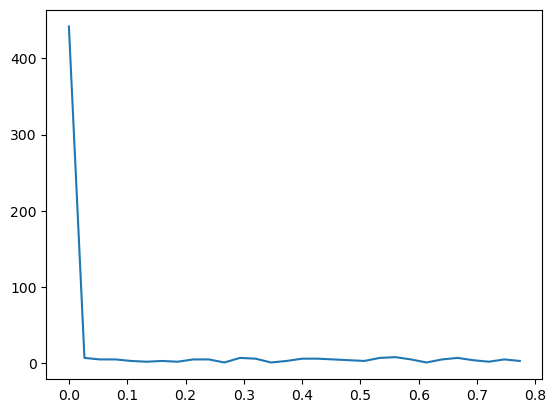

In [9]:
# plot the data on a graph to check out what is going on
hy, hx = torch.histogram(m1.block1.out, bins=30, range=(0, 0.8))
print(hy, hx)
plt.plot(hx.detach()[:-1], hy.detach())

# check the number of values that are less than or equal to 0
zero_mask1 = torch.le(m1.block1.out, 0)
zeros = m1.block1.out[zero_mask1]
one_block_layer1 = zeros.shape

print(zeros.shape)

In [10]:
# for as much consistency as possible:
torch.manual_seed(1337)

# creation of the model
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(
            num_embeddings=VOCAB_SIZE, embedding_dim=HIDDEN_LAYER
        )
        # besides the identity of the tokens, we also wish to embed the postition of the tokens
        self.position_embedding_table = nn.Embedding(
            num_embeddings=CONTEXT_LENGTH, embedding_dim=HIDDEN_LAYER
        )
        # self.blocks = nn.Sequential(
        #     Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        #     # Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        #     # Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4),
        # )
        self.block1 = Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4)
        self.block2 = Block(hidden_layer_size=HIDDEN_LAYER, no_of_heads=4)
        
        # self.multi_head = MultiHeadedAttention(4, HIDDEN_LAYER // 4)
        # self.ffwd = FeedForward(HIDDEN_LAYER, HIDDEN_LAYER)
        self.lm_head = nn.Linear(in_features=HIDDEN_LAYER, out_features=VOCAB_SIZE)

    def forward(self, x, targets=None):
        """Do a forward pass of the NN. Returns loss if targets are given"""
        # get the shape of the input so that the postitional outputs can be properly computed when the input size is less than 8
        B, T = x.shape

        token_logits: Tensor = self.token_embedding_table(x)
        postition_logits: Tensor = self.position_embedding_table(torch.arange(T))
        input_tokens = token_logits + postition_logits
        # weighted_tokens = self.multi_head(input_tokens)
        # feed_forward = self.ffwd(weighted_tokens)
        feed_forward = self.block1(input_tokens)
        feed_forward = self.block2(feed_forward)
        logits: Tensor = self.lm_head(feed_forward)

        # if there are targets present, perform a calculation of the loss
        if targets != None:
            # B: number of batches, T: the context length, C: the number of outputs
            B, T, C = logits.shape
            # order the logits in the form: (minibatch,C) to enable cross_entropy calculation
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
            return logits, loss

        return logits

In [11]:
# try to perform one training round
m2 = Model2()
optimizer = torch.optim.AdamW(params=m2.parameters(), lr=lr)

for i in range(training_rounds):
    Xtr, Ytr = get_batch(train)
    # forward pass
    logits, loss2 = m2(Xtr, Ytr)

    # print the loss at regular intervals
    if i % 1000 == 0:
        get_loss(m2, 500)

    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss2.backward()
    optimizer.step()

Train loss: 4.48165 | Val loss: 4.47936
Train loss: 2.68962 | Val loss: 2.71589
Train loss: 2.55565 | Val loss: 2.55901
Train loss: 2.47002 | Val loss: 2.49225
Train loss: 2.40517 | Val loss: 2.44486
Train loss: 2.36909 | Val loss: 2.38921
Train loss: 2.33903 | Val loss: 2.35441
Train loss: 2.29084 | Val loss: 2.33292
Train loss: 2.26867 | Val loss: 2.32475
Train loss: 2.25526 | Val loss: 2.29993


tensor([464.,   7.,  10.,   2.,   3.,   6.,   6.,   2.,   6.,   4.,   4.,   3.,
          3.,   5.,   6.,   3.,   8.,   2.,   6.,   5.,   8.,   6.,   9.,   7.,
          4.,   6.,  11.,   6.,   4.,   5.], grad_fn=<NotImplemented>) tensor([0.0000, 0.0267, 0.0533, 0.0800, 0.1067, 0.1333, 0.1600, 0.1867, 0.2133,
        0.2400, 0.2667, 0.2933, 0.3200, 0.3467, 0.3733, 0.4000, 0.4267, 0.4533,
        0.4800, 0.5067, 0.5333, 0.5600, 0.5867, 0.6133, 0.6400, 0.6667, 0.6933,
        0.7200, 0.7467, 0.7733, 0.8000], grad_fn=<NotImplemented>)
torch.Size([455])


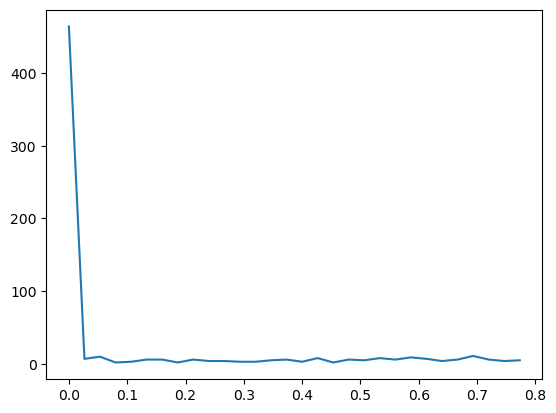

In [12]:

# plot the data on a graph to check out what is going on
hy, hx = torch.histogram(m2.block1.out, bins=30, range=(0, 0.8))
print(hy, hx)
plt.plot(hx.detach()[:-1], hy.detach())

# check the number of values that are less than or equal to 0
zero_mask1 = torch.le(m2.block1.out, 0)
zeros = m2.block1.out[zero_mask1]
two_block_layer1 = zeros.shape

print(zeros.shape)

tensor([595.,   4.,   0.,   2.,   3.,   2.,   6.,   1.,   7.,   2.,   2.,   3.,
          2.,   0.,   3.,   4.,   5.,   0.,   6.,   2.,   2.,   3.,   1.,   3.,
          2.,   3.,   3.,   4.,   4.,   0.], grad_fn=<NotImplemented>) tensor([0.0000, 0.0267, 0.0533, 0.0800, 0.1067, 0.1333, 0.1600, 0.1867, 0.2133,
        0.2400, 0.2667, 0.2933, 0.3200, 0.3467, 0.3733, 0.4000, 0.4267, 0.4533,
        0.4800, 0.5067, 0.5333, 0.5600, 0.5867, 0.6133, 0.6400, 0.6667, 0.6933,
        0.7200, 0.7467, 0.7733, 0.8000], grad_fn=<NotImplemented>)
torch.Size([593])


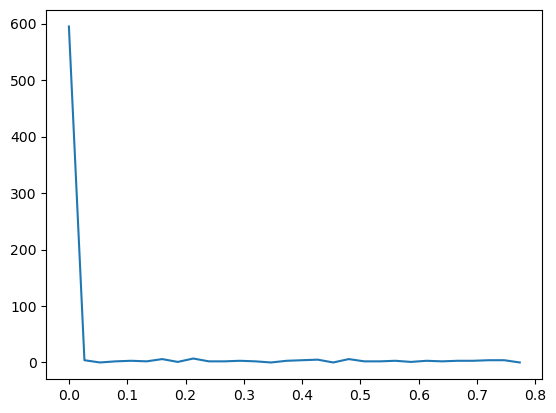

In [13]:

# plot the data on a graph to check out what is going on
hy, hx = torch.histogram(m2.block2.out, bins=30, range=(0, 0.8))
print(hy, hx)
plt.plot(hx.detach()[:-1], hy.detach())

# check the number of values that are less than or equal to 0
zero_mask1 = torch.le(m2.block2.out, 0)
zeros = m2.block2.out[zero_mask1]
two_block_layer2 = zeros.shape

print(zeros.shape)

In [14]:
three_loss = get_loss(m, loss_evals=1000)
two_loss = get_loss(m2, loss_evals=1000)
one_loss = get_loss(m1, loss_evals=1000)

Train loss: 2.30067 | Val loss: 2.33467
Train loss: 2.24283 | Val loss: 2.28012
Train loss: 2.22331 | Val loss: 2.27201


In [16]:
print("number of dead neurons for 3 layer " + str(three_block_layer1[0]), str(three_block_layer2[0]), str(three_block_layer3[0]))
print("number of dead neurons for 2 layer " + str(two_block_layer1[0]), str(two_block_layer2[0]))
print("number of dead neurons for 1 layer " + str(one_block_layer1[0]))


number of dead neurons for 3 layer 481 590 502
number of dead neurons for 2 layer 455 593
number of dead neurons for 1 layer 435


Oddly enough, the pleateuing of gradients seems to have disappeared??
Okay but I guess deeper nets get more difficult to train because there become more and more dead ReLU neurons with a gradient of 0?